In [1]:
import numpy as np

In [2]:
import serial
import struct
import time

class Maestro_Driver:
    def __init__(self, com_port, baud_rate=115200,
                 lower_pulse_bound=1100,
                 upper_pulse_bound=1900):
        '''
        Establish serial com with the MaestroMicro
        
        :param com_port - Name of the communication port the Maestro is connected to
        :param baud_rate - Typically 115200 baud for the maestro.
        :param lower_pulse_bound - The minimum pulse width in microseconds
        :param upper_pulse_bound - The maximum pulse width in microseconds
        '''
        self.com_port = com_port
        self.baud_rate = baud_rate
        self.lower_pulse_bound = lower_pulse_bound
        self.upper_pulse_bound = upper_pulse_bound

        self.usb = serial.Serial(com_port)

    def set_thrusts(self, thrusts=None):
        '''
        Convert thrust commands to pulsewidth, and send to each of the MicroMaestros 6 channels.
        
        :param thrusts - List of 6 values, each in range [-100.0, 100.0] to be mapped linearly to 
                         pulse widths to send to the maestro. Think of each values as the "percentage of motor
                         speed with respect to max motor speed"
        '''
        if thrusts is None:
            thrusts = [0, 0, 0, 0, 0, 0]
            
        old_range = (100 + 100)
        new_range = (1900 - 1100)
        pulse_width = []
        
        #populating pulse width array
        for t in thrusts:
            pulse_width.append((((t + 100) * new_range) / old_range) + 1100)
            pulse_width[-1] = round(pulse_width[-1] * 4)/4

        #packing pulse width command
        for i in range(6):
            a = int(pulse_width[i] * 4)
            lower_bits = a & 0x7f
            upper_bits = (a >> 7) & 0x7f
            pulse_width_packed = struct.pack('>hh', lower_bits, upper_bits)
            message = bytearray([0x84, i, pulse_width_packed[1], pulse_width_packed[3]])
            self.usb.write(message)

In [3]:
class PID_Controller():
    '''
    PID controller typically used in control feed back systems.
    '''
    def __init__(self, k_p, k_i, k_d, i_min=1.0, i_max=-1.0, cmd_min=1.0, cmd_max=-1.0, cmd_offset=0.0, angle_wrap=False):
        '''
        Initialize the the PID controller parameters.
        Parameters:
            k_p: Proportional gain
            k_i: Integral gain
            k_d: Derivative gain
            i_min: minimum value the integral can accumulate
            i_max: maximum value the integral can accumulate
                Setting i_max < i_min will mean that no limits are set for integral term
            cmd_min: minimum output command
            cmd_max: maximum output command
                Setting cmd_max < cmd_min will mean no limits are set for the output cmd on update.
            cmd_offset: Offset to add to the command output on each update step.
            angle_wrap: if true, it assumes the input set point and process point are angles in range
            
                        [-pi, pi]. Thus it will clamp the error in range [-pi, pi]
        Returns:
            N/A
        '''
        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d
        self.i_min = i_min
        self.i_max = i_max
        self.cmd_min = cmd_min
        self.cmd_max = cmd_max
        self.cmd_offset = cmd_offset
        self.angle_wrap = angle_wrap

        self.integral = 0.0
        self.previous_error = 0.0

    def set_gains(self, k_p, k_i, k_d):
        '''
        Reset the gain parameters.
        Parameters:
            k_p: Proportional gain
            k_i: Integral gain
            k_d: Derivative gain
        '''
        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d


    def update(self, set_point, process_point, dt):
        '''
        Perfrom a control step to correct for error in control system.
        
        Parameters:
            set_point: The current state of the system
            process_point: The desired state of the system
            dt: The interval between update steps.
        Returns:
            cmd: An PID output control value to correct for error in system
        '''
        
        #compute the error
        error = process_point - set_point
        
        #if error is for angular inputs, perform angle wrapping.
        if(self.angle_wrap):
            if(error > np.pi):
                error = error - 2*np.pi
            elif(error < -1 * np.pi):
                error = error + 2*np.pi
            
        p = (self.k_p * error) #proportional term

        self.integral = self.integral + (error * dt)
        
        if(self.i_min < self.i_max):
            if(self.integral < self.i_min):
                self.integral = self.i_min
            elif(self.integral > self.i_max):
                self.integral = self.i_max

        i = self.k_i * self.integral

        d = self.k_d * (error - self.previous_error) / dt
        self.previous_error = error

        cmd = p + i + d + self.cmd_offset
                  
        if(self.cmd_min < self.cmd_max):
            if(cmd < self.cmd_min):
                cmd = self.cmd_min
            elif(cmd > self.cmd_max):
                cmd = self.cmd_max

        return cmd, error

In [4]:
#Create a "positional" pid control system for the PICO mini auv. There will be 5 controller for
#(roll, pitch, yaw, x, z). These are the DOFs controllable by the actuator.

class Pico_PID_Controller:
    
    def __init__(self):
        '''
        '''
        
        #Initialize pid controllers
        self.z_pid = PID_Controller(0.0, 0.0, 0.0)
        self.roll_pid = PID_Controller(0.0, 0.0, 0.0, angle_wrap=True)
        self.pitch_pid = PID_Controller(0.0, 0.0, 0.0, angle_wrap=True)
        
        #matrix mapping the 5 pid controller outputs to the 6 thrusters
        # -----roll---pitch---yaw---x---z
        #| T1
        #| T2
        #| T3
        #| T4
        #| T5
        #| T6
        
        self.pid_thrust_mapper = np.array([[ 1,  1,  0,  0, 1],
                                           [ 0,  0,  1,  1,  0],
                                           [ 1, -1,  0,  0, 1],
                                           [-1, -1,  0,  0, 1],
                                           [ 0,  0, -1,  1,  0],
                                           [-1,  1,  0,  0, 1]])
        
        
    
    def update(self, set_point=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), 
                     process_point=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                     dt=0.010):
        '''
        Perform PID controller update step and return the thrust to each of the 6 thrusters.
        
        :param set_point - The desired state of the vehicle [roll, pitch, yaw, x, z] (np.array)
        :param process_point - The current state of the vehicle [roll, pitch, yaw, x, z] (np.array)
        :param dt - Update interval in seconds (float)
        
        :return thrusts - A list of length 6 of the thrusts to apply to each motor: Range [-100, 100] (np.array)
        '''
        
        roll_cmd, roll_error = self.roll_pid.update(set_point[0], process_point[0], dt)
        pitch_cmd, pitch_error = self.pitch_pid.update(set_point[1], process_point[1], dt)
        z_cmd, z_error = self.z_pid.update(set_point[5], process_point[5], dt)
        
        errors = np.array([roll_error, pitch_error, 0.0, 0.0, z_error])
        
        cmds = np.array([
            roll_cmd,
            pitch_cmd,
            0.0,
            0.0,
            z_cmd
        ])
        
        thrusts = np.matmul(self.pid_thrust_mapper, cmds)
        return(thrusts, errors)   
        

In [5]:
#Run the Pico PID Controller
#Run two threads - 1 for receiving the robot state. 1 for running the control system
import threading
import serial

class Sensor_Hub_Driver:
    
    def __init__(self, com_port, baud_rate=115200):
        
        self.com_port = com_port
        self.baud_rate = baud_rate
        self.ser = serial.Serial(self.com_port, self.baud_rate)
        
        self.HEADER_BYTE =    0xA4
        self.DEPTH_REQ_BYTE = 0x02
        self.IMU_REQ_BYTE =   0x03
        self.ALL_REQ_BYTE =   0x04
        self.END_BYTE =       0xA0
        
        
    def get_all_sensor_data(self):
        '''
        '''
        
        req_packet = bytearray([self.HEADER_BYTE, self.ALL_REQ_BYTE, self.END_BYTE])
        self.ser.write(req_packet)
        return(self._unpack(self.ALL_REQ_BYTE))
    
    def _unpack(self, requested_packet_type):
        '''
        Unpack the data received after a request is sent to the motherboard.
        Only receive the packet type requested
        '''
        
        if self.ser.in_waiting > 0:
            header_byte = ord(self.ser.read())
            
            if(hex(header_byte) == hex(self.HEADER_BYTE)):
                msg_type = ord(self.ser.read())
                
                if((hex(msg_type) == hex(self.ALL_REQ_BYTE)) and (requested_packet_type == self.ALL_REQ_BYTE)):
                    
                    data_temp = self.ser.read(16)
                    data = struct.unpack('<ffff', data_temp)
                    
                else:
                    return(None)
                
                end_byte = ord(self.ser.read())
                if(hex(end_byte) == "0xa0"):
                    return(data)
                else:
                    return(None)
            else:
                return(None)
        
class State_Estimator(threading.Thread):
    
    def __init__(self, dt=0.010):
        '''
        '''
        threading.Thread.__init__(self)
        
        self.run_thread = True
        
        self.sensor_hub = Sensor_Hub_Driver('/dev/picoM', 115200)
        
        #[roll, pitch, yaw, x, y, z, droll, dpitch, dyaw, dx, dy, dz]
        self.state = np.zeros(12)
        self.prev_state = np.zeros(12)
        self.dt = dt #update rate of receiving requests
        
        self.daemon = True
        
    def _angle_wrapped_error(self, angle_1, angle_2):
        
        error = angle_1 - angle_2
        
        if(error > np.pi):
            error = error - 2*np.pi
        elif(error < -1 * np.pi):
            error = error + 2*np.pi
        
        return(error)
        
    def run(self):
        self.cnt = 0
        
        while(self.run_thread):
            
            try:
                
                #Receive all the sensor data
                sensor_data = self.sensor_hub.get_all_sensor_data()
                if(sensor_data != None):
                    [roll, pitch, yaw, z] = sensor_data
                    x = 0.0
                    self.state[0] = roll
                    self.state[1] = pitch
                    self.state[2] = yaw
                    self.state[3] = x
                    self.state[4] = 0.0 #needs to be solved by state estimator
                    self.state[5] = z
                    
                    self.state[6] = self._angle_wrapped_error(roll, self.prev_state[0]) / self.dt
                    self.state[7] = self._angle_wrapped_error(pitch, self.prev_state[1]) / self.dt
                    self.state[8] = self._angle_wrapped_error(yaw, self.prev_state[2]) / self.dt
                    self.state[9] = (x - self.prev_state[3]) / self.dt
                    self.state[10] = 0.0
                    self.state[11] = (z - self.prev_state[5]) / self.dt
                        
                    
                    self.prev_state = np.copy(self.state)
                #TODO: Perform EKF
                self.cnt = self.cnt + 1
                
                time.sleep(self.dt)

            except Exception as e:
                print("[ERROR]: State Estimator ran into an error: ", e)

In [6]:
class PID_Control_System(threading.Thread):
    
    def __init__(self, state_estimator, maestro_driver, dt=0.010):
        
        threading.Thread.__init__(self);
        self.state_estimator = state_estimator
        
        #Connect to the Maestro to control the thrusters
        self.maestro_driver = maestro_driver
        
        self.dt = dt
        self.controller = None
            
        self.controller = Pico_PID_Controller()
        
        self.desired_state = np.zeros(12)
        self.run_thread = True
        self.daemon = True
    
    def run(self):
        '''
        Runs the control system in a thread.
        '''
        #For testing only
        max_run_time = 10.0
        start = time.time()
        curr_run_time = 0.0
        self.z_error = []
        
        while(self.run_thread and (curr_run_time < max_run_time)):
            
        
            #Get the state of the vehicle
            current_state = state_estimator.state
                
            thrusts, errors = self.controller.update(self.desired_state, current_state)
            
            self.z_error.append(errors[-1])
            
            self.maestro_driver.set_thrusts(thrusts)
                
            clear_output(wait=True)
            display(current_state)
            curr_run_time = (time.time() - start)
            time.sleep(self.dt)
        
        self.run_thread = False
        print("exit")

In [19]:
from random import uniform
import time
from IPython.display import display, clear_output

#start the state estimator thread
state_estimator = State_Estimator()
state_estimator.start()

#Driver to control the thrusters
maestro_driver = Maestro_Driver('/dev/picoMaestroM')
    
control_system = PID_Control_System(state_estimator, maestro_driver, dt=0.010)

#Set the z_pid controller parameters
control_system.controller.z_pid.set_gains(5.0, 0.0, 0.0)
control_system.controller.z_pid.cmd_offset = -15.0
control_system.controller.z_pid.cmd_min = -16.0
control_system.controller.z_pid.cmd_max = 0.0

#set the roll_pid controller parameters
#control_system.controller.roll_pid.set_gains(20.0, 0.0, 0.0)
control_system.controller.roll_pid.cmd_offset = 0.0
control_system.controller.roll_pid.cmd_min = -5.0
control_system.controller.roll_pid.cmd_max =  5.0

#set the pitch_pid controller parameters
#control_system.controller.pitch_pid.set_gains(2.0, 0.0, 0.0)
control_system.controller.pitch_pid.cmd_offset = 0.0
control_system.controller.pitch_pid.cmd_min = -1.00
control_system.controller.pitch_pid.cmd_max =  1.0


control_system.desired_state = np.array([0.0, 0.0, 0.0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0])
control_system.start()

array([-3.11330128, -0.18509406, -0.11056764,  0.        ,  0.        ,
        0.16529228,  3.52156798, -0.28872639, -0.28943345,  0.        ,
        0.        , -0.32589138])

exit


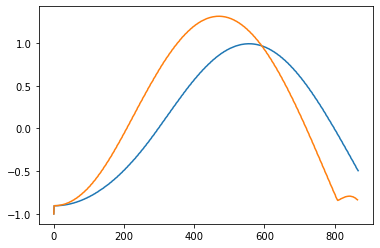

In [20]:
import matplotlib.pyplot as plt
control_system.run_thread = False
state_estimator.run_thread = False
maestro_driver.usb.close()
state_estimator.sensor_hub.ser.close()
try:
    plt.plot(z_error_prev)
except:
    pass

plt.plot(control_system.z_error)
z_error_prev = control_system.z_error
#plt.hlines(0.0, 0, 900)

In [ ]:
control_system.run_thread